In [3668]:
import networkx as nx
import requests
import json
import matplotlib.pyplot as plt


#['app2', 'app5']
#5afdb8cf93beb10025c13f4f
url = 'localhost:5010'
entries = ['app5', 'app6']
rolesa = '593f49be42d3ed97390f25a7'

url = '10.168.20.20:5010'
entries = ['app2', 'app5']
rolesa = '5afdb8cf93beb10025c13f4f'

url = '10.168.20.20:5010'
entries = ['app2']
rolesa = '5afdb8cf93beb10025c13f4f'

In [3669]:
pipeline = [
    {'$match': {'name': {'$in': entries}, 'roles._id': rolesa}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {'name': 1, 'deps': 1, 'deps': 1, 'nodes.name': 1, 'nodes.steps': 1, 'nodes.deps': 1}}
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()
print(data)

{'items': [{'name': 'app2', 'nodes': [{'name': 'DB - O', 'steps': 1}, {'name': 'cd2', 'steps': 0, 'deps': [{'name': 'lb2', '_id': '5b35644d56d5b20025546a93', 'family': 'Loadbalance', 'endpoint': 'rest'}, {'name': 'lb3', '_id': '5b44f6b4d7f17a0025e48d35', 'family': 'Loadbalance', 'endpoint': 'rest'}]}, {'name': 'app20', 'steps': 0, 'deps': [{'name': 'DB - O', '_id': '5b462be6d7f17a0025e48d3a', 'family': 'Database', 'endpoint': 'rest'}, {'name': 'app30', '_id': '5b467f29d7f17a0025e48d3f', 'family': 'Application', 'endpoint': 'rest'}, {'name': 'Db - mysql', '_id': '5b3d1a70d7f17a0025e48d32', 'family': 'Database', 'endpoint': 'rest'}]}, {'name': 'lb3', 'steps': 0}, {'name': 'app30', 'steps': 1}, {'name': 'app 11', 'steps': 1, 'deps': [{'name': 'app20', '_id': '5b465c47d7f17a0025e48d3e', 'family': 'Application', 'endpoint': 'rest'}, {'name': 'Db - mysql', '_id': '5b3d1a70d7f17a0025e48d32', 'family': 'Database', 'endpoint': 'rest'}]}, {'name': 'lb2', 'steps': 0}, {'name': 'app3', 'steps': 0,

In [3670]:

class BaseNetwork(object):
    def __init__(self, G=nx.DiGraph):
        self.graph = G()
        self.clear_duplicate()

    def create_edge(self, item):
        if 'deps' in item:
            for dps in item['deps']:
                w = item.get('steps', -1)
                self.graph.add_edge(item['name'], dps['name'], weight=w+1)

    def create_node(self, node_id, item, root = False):
        if node_id not in self.duplicate:
            self.graph.add_node(node_id, uid=item.get('_id'), label=item.get('name'), root=root, object=item)
            self.duplicate.append(node_id)

    def make(self, data, i=0):
        for item in data:
            self.create_node(item['name'], item, i is 0)
            
            if 'nodes' in item and len(item['nodes']) > 0:
                self.make(item['nodes'], i+1)
                
            self.create_edge(item)
            
        self.clear_duplicate()   
        return self

    def get_graph(self):
        return self.graph

    def clear_duplicate(self):
        self.duplicate = []
    
class DrawNetwork(object):

    def __init__(self, G):
        self.graph = G
        
    def get_cardials(self):
        return nx.circular_layout(self.graph)
    
    
    def save_svg(self, options, labels):
        #plt.figure(figsize=(4, 4))
        pos = self.get_cardials()

        nx.draw(self.graph, pos, **options)

        labels = nx.get_edge_attributes(self.graph,'weight')
        nx.draw_networkx_edge_labels(self.graph,pos,edge_labels=labels)

        plt.axis('equal')
        plt.show()
        return pos

network = BaseNetwork()
network.make(data.get('items')).get_graph()

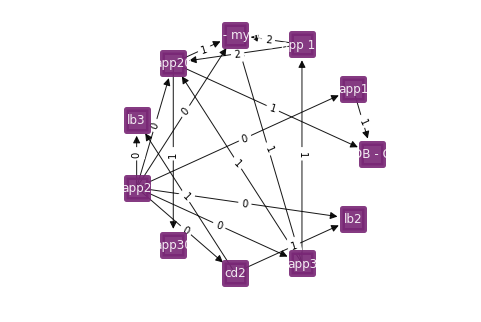

{'cd2': array([-0.14231501, -0.98982143]), 'DB - O': array([1., 0.]), 'app 11': array([0.41541505, 0.90963196]), 'Db - mysql': array([-0.14231483,  0.98982143]), 'app20': array([-0.65486066,  0.75574964]), 'lb3': array([-0.95949297,  0.28173262]), 'app2': array([-0.95949297, -0.28173256]), 'app30': array([-0.65486072, -0.75574958]), 'lb2': array([ 0.84125346, -0.54064089]), 'app1': array([0.84125352, 0.54064077]), 'app3': array([ 0.41541511, -0.90963196])}


In [3671]:
options = {
    'with_labels': True,
    'arrowsize': 15,
    'node_shape': 's',
    'node_size': 500,
    'node_color': '#782675',
    'font_color': 'white',
    'alpha': 0.9,
    'linewidths': 5
}

labels = {
    'font_weight': 'bold'
}

draw = DrawNetwork(network.graph)
draw.save_svg(options, labels)

print(draw.get_cardials())

In [3672]:
G=network.graph
#nei = list(network.graph.neighbors('app1'))
#print(nei)

#network.graph.degree['app1']

#G.out_degree('app1')
#G.in_degree('app1')

In [3673]:

from svgwrite import Drawing
from operator import itemgetter
from IPython.display import SVG, display
from networkx.classes.reportviews import OutEdgeView

In [3674]:
pagerank = nx.pagerank(G, alpha=0.9)
print(pagerank)

density = nx.density(G)
print(density)

hist = nx.degree_histogram(G)

{'DB - O': 0.14882456565429394, 'app 11': 0.07847162009112378, 'Db - mysql': 0.14791898739873136, 'app20': 0.11378379242593473, 'lb3': 0.08752605773871716, 'app2': 0.060362744795937014, 'cd2': 0.060362744795937014, 'app30': 0.09449793976873364, 'lb2': 0.08752605773871716, 'app1': 0.060362744795937014, 'app3': 0.060362744795937014}
0.16363636363636364


In [3675]:
import collections

class Histogram(object):
    def __init__(self):
        self._hist = None
        
    def set_collections(self, data):
        self._hist = collections.Counter(data)
        return self
        
    def get_counter(self):
        return dict(self._hist)
    
    def max_columm(self):
        if self._hist is not None:
            return self._hist.most_common(1)[0]
    
    def max_value(self):
        n = self.max_columm()
        if n:
            return n[1]    
    
class GridHistogram(Histogram):
    def __init__(self, grid):
        super().__init__()
        self.grid = grid
        self.make()
    
    def make(self):
        clear = {}
        
        for key, value in self.grid.items():
            clear[key] = len(value)
   
        self.set_collections(clear)
        
class GraphHistogram(Histogram):
    
    def __init__(self, G):
        super().__init__()
        self.graph = G
        self.make()
    
    def find_weight(self, item, weight=0):
        root = self.graph.nodes[item].get('root')
        
        if not root:
            pred = self.graph.in_edges(item, data=True)

            if pred and len(list(pred)) > 0:
                weight = max([it[2].get('weight') for it in pred]) + 1
        
        return weight

    def make(self):
        nodes = self.graph.nodes()
        weights = []
        
        for node in nodes:
            w = self.find_weight(node)
            weights.append(w)
            self.graph.nodes[node]['weight'] = w
    
        self.set_collections(weights)
 
        
GraphHistogram(G).get_counter()

{0: 1, 1: 3, 2: 5, 3: 2}

In [3676]:

class DefsSVG(object):
    
    def __init__(self, draw):
        self.dwg = draw

    def app(self, pos, title, size=(20,20), unit="px"):
        opts = {
            'size': ("%s%s"%(size[0], unit), "%s%s"%(size[1], unit)),
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(255,255,0)"
        }
        
        self.add(self.dwg.rect(insert = pos, **opts))
        self.add(self.dwg.text(title, insert=(pos[0], pos[1]+10), fill='red'))
    
    def line(self, cx, cy):
        opts = {
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(0,0,0)"
        }
        
        self.add(self.dwg.line(start=cx, end=cy, **opts))
    
    def add(self, svg):
        self.dwg.add(svg)
        
class DrawArea(object):
    def __init__(self, off, size, hist, nmax):
        self._off = off
        self._size = size
        self._hist = hist
        self._nmax = nmax
        
    def cal_area(self, n, pointer):
        return (n * self._size[pointer]) + (n * self._off[pointer])
    
    def area(self):
        area_y = self.cal_area(self._nmax, 1)
        area_x = self.cal_area(max(self._hist, key=int) + 1, 1)
        return (area_x, area_y)
    
class DrawSVG(object):
    def __init__(self, hist, nmax, darea=DrawArea, draw=Drawing, defs=DefsSVG):
        self._off = (40, 40)
        self._size = (20, 20)
    
        self._hist = hist
        self._nmax = nmax
        
        self._area = darea(self._off, self._size, hist, nmax).area()
        self.dwg = Drawing('test.svg', size=self._area)
        self._grid_defs = defs(self.dwg)
    
    def draw_app(self, pos, w, label):
        pos = self.cal_off(pos, w)
        self._grid_defs.app(pos, label, self._size)
    
    def draw_connect(self, pos1, pos2, w1, w2):
        pos1 = self.cal_pos_line(pos1, w1, self._size[0])
        pos2 = self.cal_pos_line(pos2, w2)
        
        self._grid_defs.line(pos1, pos2)
   
    def cal_off(self, pos, w):
        x = self.cal_offx(pos[0], w)
        y = self.cal_offy(pos[1], w)
        
        return (x, y)
        
    def cal_offy(self, y, w):  
        off = 0
        #if self._hist[w] < self._nmax:
        #    off = (self._nmax - self._hist[w]) / 2
        #    off = off * (self._off[1] + self._size[1])
        
        return (y * self._off[1]) + (y * self._size[1]) + off 
    
    def cal_offx(self, x, w):
        return (x * self._off[0]) + (x * self._size[0])
    
    def cal_pos_line(self, pos, w, suff_x=0):
        apos = self.cal_off(pos, w)
        y = apos[1] + (self._size[1]/2)
        x = apos[0] + suff_x
        
        return (x, y)
    
    def save(self):
        self.dwg.save()
        
class DrawLayout(object):
    def __init__(self, grid, gridhist=GridHistogram, draw=DrawSVG):
        
        self._grid = grid
        
        GridHistogram = gridhist(self._grid.get_grid())
        self._nmax = GridHistogram.max_value()
        self._hist = GridHistogram.get_counter()
        
        self.drawer = draw(self._hist, self._nmax)

    def draw_nodes(self):
        data = self._grid.get_grid()
        for col_k, columm in data.items():
            for line_k, label in columm.items():
                self.drawer.draw_app((col_k, line_k), col_k, label)
        
        return self
    
    def draw_connections(self, edges):
        for edge in edges:
            pos = []
            w = []
            
            for i in range(2):
                ipos = self._grid.get_pos(edge[i])
                pos.append(ipos)
                w.append(ipos[0])

            self.drawer.draw_connect(*pos, *w)
            
        return self 
    
    def save(self):
        self.drawer.save()

In [3677]:
class GPos(object):
    
    def __init__(self):
        self._dummies = []
        self._positions = []
        self._swift = []
        self._size = 1
        
    def append_dummy(self, dummy):
        self._dummies.append(dummy)
        
    def append_swap(self, swap):
        self._swaps.append(swap)
        
    def append_swift(self, node, swift):
        self._swift.append((node, swift))
        
    def set_position(self, pos):
        self._positions = pos
        
    def set_size(self, size):
        self._size = size
        
    def inc_size(self, inc=1):
        self._size += inc
    
    def get_size(self):
        return self.get_positions()[3]
    
    def get_x(self):
        return self.get_positions()[0]
    
    def get_y(self):
        return self.get_positions()[1]
    
    def get_positions(self):
        return self._get('positions')
    
    def get_dummies(self):
        return self._get('dummies')
    
    def get_swap(self):
        return self._get('swap')
    
    def _get(self, item):
        prop = '_'+item
        data = getattr(self, prop)
        return data
    
class GridMap(object):
    def __init__(self, finder):
        self.clean()
        
        self.finder = finder
        self.finder.set_grid(self.grid)
        self.finder.set_index(self.index)
    
    def add_pos_grid(self, node):
        gpos = self.finder.give_pos(node)
        label = node.get('label')
        
        if isinstance(gpos, GPos):
            if gpos._dummies:
                self.create_dummies(gpos._dummies, label)
                
            if gpos._positions:
                self.create_positions(gpos._positions, label, gpos._size)
                
            if gpos._swift:
                self.make_swifts(gpos._swift)
                
        return gpos
    
    def create_dummies(self, pos, label):
        if isinstance(pos, (tuple)):
            self.add_dummy(pos)

        if isinstance(pos, (list)):
            for p in pos:
                self.add_dummy(p)
                
    def create_positions(self, pos, label, size=1):
        self.index[label] = (*pos, size)
        return self._add_grid(*pos, label)
    
    def make_swifts(self, swifts):
        if isinstance(swifts, (list)):
            for swt in swifts:
                self.make_swift(swt[0], swt[1])
    
    def make_swift(self, switch, loc):
        node = switch.get('label')
        pos = self.index[node]
        
        del self.grid[pos[0]][pos[1]]
        del self.index[node]
        
        
        max_x = max(self.grid, key=int)
        newdic = {}
        
        for columm in range(max_x, pos[0], -1): 
            newdic[columm] = self.grid[columm]
            del self.grid[columm]
            
        print(newdic)
        for nline in newdic:
            print(nline)
            for ncol in newdic[nline]:
                ccnode = newdic[nline][ncol]
                
                if ccnode in self.index:
                    npos = self.index[ccnode]
                    del self.index[ccnode]
                
                
                    self.create_positions((npos[0]+1, npos[1]), ccnode, npos[2])
            
        
        self.create_positions((loc+1, pos[1]), node, pos[2])
        print(node, "-- ", pos[0])
        
        
        
        
        
    def add_dummy(self, pos):  
        return self._add_grid(*pos, '-')
    
    def _add_grid(self, x, y, item):
        if x not in self.grid:
            self.grid[x] = {}
            
        self.grid[x][y] = item
        return (x, y)

    def get_pos(self, item):
        if item in self.index:
            return self.index[item]
    
    def get_grid(self):
        return self.grid  
    
    def clean(self):
        self.grid = {}
        self.index = {}

In [3678]:
class PositionCrawlerHelper(object):

    def __init__(self, node, index, G):
        self._graph = G
        self._node = node
        self._index = index
        
        self._step = self.get_step()
        self._direct_succers = []
        self._subdirect_succers = []

    def successors(self):
        return (self.only_direct_successors(), self.only_subdirect_successors())
    
    def only_direct_successors(self):
        self.categorize_successors()
        return self._direct_succers
    
    def only_subdirect_successors(self):
        self.categorize_successors()
        return self._subdirect_succers
    
    def categorize_successors(self):
        succers = self._graph[self.get_id()]
        
        if (len(succers) > 0) and (not self._direct_succers):
            for node in succers:
                wg = self.get_weight(node)
                
                diff = wg - self._step
                if diff is 1:
                    self._direct_succers.append(node)
                else:
                    self._subdirect_succers.append(node)
      
    def get_weight(self, node):       
        if node in self._index:
            return self._index[node][0]
        
        return self._graph.nodes[node].get('weight')
    
    def get_step(self):
        node = self._node.get('label')
        
        if node in self._index:
            return self._index[node][0]
        
        predecessors = list(self._graph.predecessors(self.get_id()))
        default_x = self._node.get('weight')
        
        if len(predecessors) > 0:
            most = 0
            
            for pre in predecessors:
                wn = self.get_weight(pre)
                diff = wn - default_x
                if most < diff:
                    most = diff
                    default_x = wn + 1
        
        return default_x
    
    def get_id(self):
        return self._node['label']
    
class PositionCrawler(object):
    def __init__(self, node, grid, G, index, Helper=PositionCrawlerHelper):
        self._helper = Helper(node, index, G)
        
        self._grid = grid
        self._node = node
        self._step = self._helper.get_step()
        self._index = index
        self._graph = G
        
        self._gpos = GPos()
        self._options = {
           'max_inter': 30
        }
        
     
    def get_gpos(self):
        return self._gpos
    
    def defaults(self, args=None):
        self._gpos.set_position((self._default_x(), self._default_y()))
        
    def _default_y(self):
        return self._max_empty_y(self._step)
        
    def _max_empty_y(self, step):
        if step not in self._grid:
            return 0
        
        return max(self._grid[step], key=int) + 1

    def has_pos(self, x, y):
        return (x in self._grid) and (y in self._grid[x])
      
    def _default_x(self):
        return self._step
    
class PositionCrawlerPattern(PositionCrawler):
        
    def soft_balance(self, step_pace=1):
        succers = self._helper.only_direct_successors()
        succers_size = len(succers)
        
        start_y = self._default_y()

        nstep = self._step + step_pace
        nposy = self._max_empty_y(nstep)
        
        if (succers_size > 0) and (start_y > nposy):
            diff = start_y - nposy
            for i in range(diff):
                posy = nposy + i
                self._gpos.append_dummy((nstep, posy))
    
    def child_balance(self, ):
        succers, subsuccers = self._helper.successors()
        succers_size = len(succers)
        
        succers_size += 1 if len(subsuccers) >= 1 else 0 # if chess hourse is actived, put one more line

        if succers_size >= 2:
            self.balance_nodes(succers_size-1)
            self.grow_node(succers_size)
     
    def chess_hourse(self):
        succers = self._helper.only_subdirect_successors()
        
        if len(succers) >= 1:
            posy = self._max_empty_y(self._step)
            
            for item in succers:
                subnode = self._graph.nodes[item]
                
                w = self._helper.get_weight(subnode.get('label'))
                switch_y = self.chess_hourse_eligible_y(subnode, w)
                
                diff = ((w+switch_y) - self._step) - 1
                self.chess_hourse_dummie(diff, posy)
                

    def chess_hourse_dummie(self, diff, posy):
        for rg in range(diff):
            nstep = self._step + rg + 1

            if not self.has_pos(nstep, posy):
                self._gpos.append_dummy((nstep, posy))
        
    def chess_hourse_find_y(self, y1, y2, step, node):
        found = False
        
        for it in range(y2-1, y1-1, -1):
            if (step in self._grid) and (self._grid[step].get(it, '-') is not '-'):
                if self._grid[step][it] is node:
                    found = True
                break
        return found
    
    def chess_hourse_recursive_y(self, step):
        found = step
        
        while True:
            check = self._max_empty_y(step)
            if check <=1:
                break
            step += 1
        return step
        
    def chess_hourse_eligible_y(self, subnode, w):
        label = subnode.get('label')
        diff = 0
        
        if label in self._index:
            mypos = self._index[label]
            eligible_y = self._max_empty_y(w)
            
            last_node_in_line = self.chess_hourse_find_y(mypos[1], eligible_y, mypos[0], label)

            diff = (mypos[0]+1) - w
            if not last_node_in_line:
                nstep = self.chess_hourse_recursive_y(w)
                diff = (nstep+1) - w
                self._gpos.append_swift(subnode, diff)
            
        return diff
        
    def grow_node(self, total):
        start_y = self._default_y()
        
        for ps in range(total-1):
            nps = (self._step, start_y + (ps+1))
            self._gpos.append_dummy(nps)
            self._gpos.inc_size()
            
    def balance_nodes(self, qtd):
    
        for nl in range(self._step):
            last = self._max_empty_y(nl)

            for np in range(qtd):
                posy = last + np
                self._gpos.append_dummy((nl, posy))
                
    def set_position(self):
        start_y = self._default_y()
        self._gpos.set_position((self._default_x(), start_y))
            
            
            
class PositionCrawlerIterator(object):
    
    def __init__(self, Pattern):
        self._pattern = Pattern
    def map(self):
        return ['chess_hourse','soft_balance', 'child_balance', 'set_position']
        
    def find_rule(self):
        for check in self.map():
            getattr(self._pattern, check)()
    
    
class PositionFinder(object):
    def __init__(self, G, gridhist=GraphHistogram):
        
        self._grid = {}
        self._index = {}
        self._graph = G
        
        GridHistogram = gridhist(G)
        self._nmax = GridHistogram.max_value()
        self._hist = GridHistogram.get_counter()

    def set_grid(self, grid):
        self._grid = grid
        
    def set_index(self, index):
        self._index = index
        
    def give_pos(self, node, CPattern=PositionCrawlerPattern, CIterator=PositionCrawlerIterator):        
        Patterns = CPattern(node, self._grid, self._graph, self._index)
        CIterator(Patterns).find_rule()
        
        return Patterns.get_gpos()

In [3679]:
class GridOrchestrator(object):
    
    def __init__(self, G, finderpos=PositionFinder):
        self._graph = G
        
        FinderPosition = finderpos(G) #hooked system, which position
        self._grid_map = GridMap(FinderPosition) # Control each position
        
        
    def create(self, entries):
        self._recursive_draw(entries)
    
    def get_grid(self):
        return self._grid_map
    
    def _recursive_draw(self, app, i=0):
        if i>30:
            return
        
        for item in app:
            if self._grid_map.get_pos(item) is None:
                node = self._graph.nodes[item]
                self._grid_map.add_pos_grid(node)
                
                succ = self._graph.successors(item)
                self._recursive_draw(succ, i+1)

-------------------------
{4: {0: 'app30', 1: 'DB - O', 3: '-'}, 5: {3: '-'}}
4
5
app20 --  3
{0: {0: 'app2', 1: '-', 2: '-', 3: '-', 4: '-', 5: '-', 6: '-'}, 1: {0: '-', 1: 'cd2', 2: '-', 3: 'app3', 4: '-', 5: '-', 6: 'app1'}, 2: {0: '-', 1: 'lb3', 2: 'lb2', 3: '-', 4: 'app 11', 5: '-', 6: '-'}, 3: {1: 'Db - mysql', 3: '-', 4: '-', 6: '-'}, 4: {0: 'app20', 4: '-', 6: '-'}, 5: {0: 'app30', 1: 'DB - O', 6: '-'}}
{'DB - O': (5, 1, 1), 'app1': (1, 6, 1), 'app 11': (2, 4, 2), 'Db - mysql': (3, 1, 1), 'app20': (4, 0, 1), 'app30': (5, 0, 1), 'app2': (0, 0, 4), 'app3': (1, 3, 2), 'lb3': (2, 1, 1), 'cd2': (1, 1, 2), 'lb2': (2, 2, 1)}


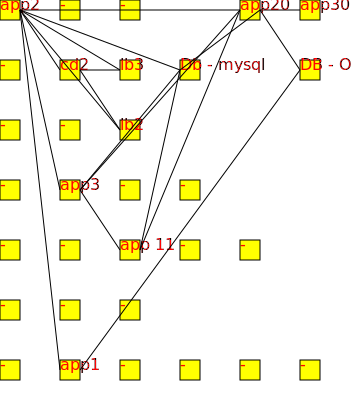

In [3680]:
print("-------------------------")
Orchestration = GridOrchestrator(G)
Orchestration.create(entries)

Layout = DrawLayout(Orchestration.get_grid())
Layout.draw_nodes()
Layout.draw_connections(G.edges())
Layout.save()

print(Orchestration.get_grid().get_grid())
print(Orchestration.get_grid().index)
   
display(SVG(filename='test.svg'))